# Exploratory model training on minibatch
Trying out som different models to build a pipeline to be trained on the whole dataset.

In [2]:
# Imports
import numpy as np
import polars as pl
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV




In [3]:
# Import np arrays
X = np.load('../data/processed/pln_X_small_features_raw_128x128.npy')
y = np.load('../data/processed/pln_y_small_labels.npy')

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.23, 
    random_state=42,
    stratify=y
)

In [5]:
# Scaling

scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Models
rfc = RandomForestClassifier(random_state=42)
knc = KNeighborsClassifier()
svc = SVC()
lr = LogisticRegressionCV()

In [7]:
# GridSearch hyperparameters

# RandomForestClassifier
n_estimators = [50, 100, 150]
max_depth = [None, 10, 20, 30]
min_samples_split = [2, 5, 10]

# KNeighborsClassifier
n_neighbors = [2, 5, 10]
weights = ['uniform', 'distance']
metric = ['minkowski', 'euclidean']

# SVC
svc_c = [0.5, 1, 2]
kernel = ['rbf', 'poly', 'sigmoid']

# LogisticRegressionCV
lr_c = [5, 10, 15]
max_iter = [100, 300]
param_grid_l1 = {'penalty': ['l1'], 'solver': ['liblinear'], 'Cs': lr_c, 'max_iter': max_iter}
param_grid_l2 = {'penalty': ['l2'], 'solver': ['lbfgs'], 'Cs': lr_c, 'max_iter': max_iter}
param_grid_elasticnet = {'penalty': ['elasticnet'], 'solver': ['saga'], 'Cs': lr_c, 'max_iter': max_iter}


model_and_param_dict = {
    'rfc': (
        rfc, 
        {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split
        }
    ),
    'knc': (
        knc,
        {
            'n_neighbors':n_neighbors,
            'weights': weights,
            'metric': metric
        }
    ),
    'svc': (
        svc,
        {
            'C': svc_c,
            'kernel': kernel
        }
    ),
    'lr': (
        lr,
        [param_grid_l1, param_grid_l2, param_grid_elasticnet]
    ),
}


In [8]:
# Using GridSearchCV - hyperparams
all_results = {}

for name, (model, param_grid) in model_and_param_dict.items():
    start = time.time()
    grid = GridSearchCV(model, param_grid, n_jobs=-1)
    grid.fit(X_trained_scaled, y_train)
    end = time.time()
    elapsed = end - start
    all_results[name] = grid
    print(name, elapsed, grid.best_score_, grid.best_params_)

rfc 38.481797218322754 0.9272727272727274 {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
knc 2.28240704536438 0.9272727272727271 {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
svc 30.03382420539856 0.922077922077922 {'C': 2, 'kernel': 'rbf'}


/home/fendraq/wsl_projects/machine_learning/examination_ai_application/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fendraq/wsl_projects/machine_learning/examination_ai_application/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fendraq/wsl_projects/machine_learning/examination_ai_application/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimato

lr 325.317081451416 0.9220779220779219 {'Cs': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


Short conclusion - Per run
- rfc 33.92333912849426 0.9324675324675324 {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
- rfc 40.69220590591431 0.92987012987013 {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 150}
- rfc 36.66754484176636 0.935064935064935 {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
 - Do a more deep check on RandomForest, because giving different hyperparams every time.
 - random_state=42: rfc 40.778780460357666 0.9324675324675324 {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 150}

- knc 1.8457927703857422 0.9272727272727271 {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
- knc 2.0355379581451416 0.9272727272727271 {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
- knc 1.8316137790679932 0.9272727272727271 {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}


- scv 20.9615638256073 0.922077922077922 {'C': 2, 'kernel': 'rbf'}
- scv 30.243993759155273 0.922077922077922 {'C': 2, 'kernel': 'rbf'}
- scv 21.740108966827393 0.922077922077922 {'C': 2, 'kernel': 'rbf'}


- lr 82.70813989639282 0.9220779220779219 {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
- lr 82.44416189193726 0.9220779220779219 {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
- lr 84.15539336204529 0.9220779220779219 {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}




## Comparison of the models

In [9]:
# Saving best estimator
best_rfc = all_results['rfc'].best_estimator_
best_knc = all_results['knc'].best_estimator_
best_svc = all_results['svc'].best_estimator_
best_lr = all_results['lr'].best_estimator_

In [10]:
# Defining a estimator evaluator function
def model_evaluator(model, X_test_scaled, y_test):
    """ Gives estimator results and visualizations of a classification problem """
    # Basic scores
    y_pred = model.predict(X_test_scaled)
    """ print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred)) """
    print(classification_report(y_test, y_pred))

    # CM
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for estimator {model}")
    plt.show()

    # ROC and AUC
    """ try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test_scaled)
        else:
            raise AttributeError("Model has neither predict_proba or decision_function")   
    
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive rate")
        plt.ylabel("Trupe Positive Rate")
        plt.title(f"ROC Curve for {model}")
        plt.legend()
        plt.show() """

        # Precision-Recall
    """ precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        plt.plot(precision, recall)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall for {model}")
        plt.show() """

    """ except Exception as e:
        print("Roc/Precision-recall plot skipped: ", e)
 """
    # Residuals
    """ residuals = y_test - y_pred
    plt.hist(residuals, bins=[-1, 0, 1])
    plt.xlabel("Residual (y_test - y_pred)")
    plt.ylabel("Count")
    plt.title(f"Residual analysis for {model}")
    plt.show()
 """
    # Decision boundaries
    """ x_min, x_max = X_test_scaled[:, 0].min() - 1, X_test_scaled[: , 0].max() + 1
    y_min, y_max = X_test_scaled[:, 1].min() - 1, X_test_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2)
    correct = y_pred == y_test
    plt.scatter(X_test_scaled[correct, 0], X_test_scaled[correct, 1], c='g', label='Correct')
    plt.scatter(X_test_scaled[~correct, 0], X_test_scaled[~correct, 1], c='r', label='Incorrect')
    plt.legend()
    plt.title(f"Decision boundaries and classification results for {model}")
    plt.show() """





### Evaluation RandomForestClassifier

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        99
           1       0.86      0.38      0.52        16

    accuracy                           0.90       115
   macro avg       0.88      0.68      0.73       115
weighted avg       0.90      0.90      0.89       115



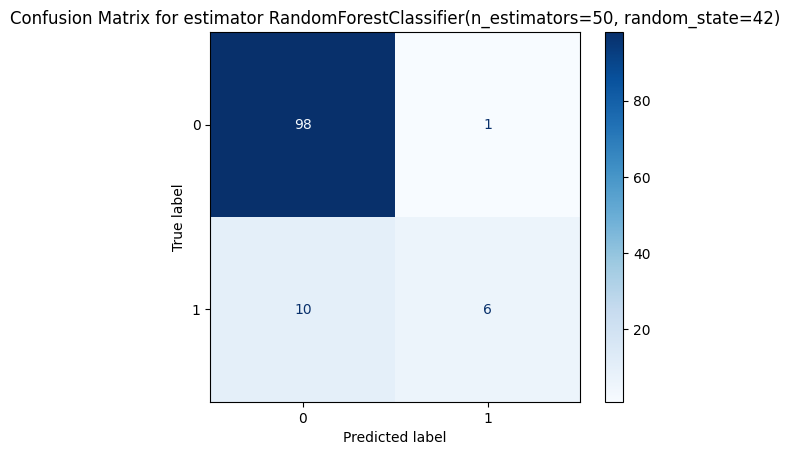

In [11]:
# Evaluation RandomForestClassifier
model_evaluator(best_rfc, X_test_scaled, y_test)



### Conclusion of RandomForestClassifier
- Increase recall (lower threshold 0.3, 0.4 for TP) and recalculate F1
- (Try PCA)
- Try class_weight='balanced'
- Maybe use feature selection with either SelectKBest or VarianceThreshold
- Visualize feature importance.


In [12]:
y_proba = best_rfc.predict_proba(X_test_scaled)[:, 1]
threshold = 0.3
y_pred_lower = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_lower))
print(confusion_matrix(y_test, y_pred_lower))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        99
           1       0.71      0.62      0.67        16

    accuracy                           0.91       115
   macro avg       0.83      0.79      0.81       115
weighted avg       0.91      0.91      0.91       115

[[95  4]
 [ 6 10]]


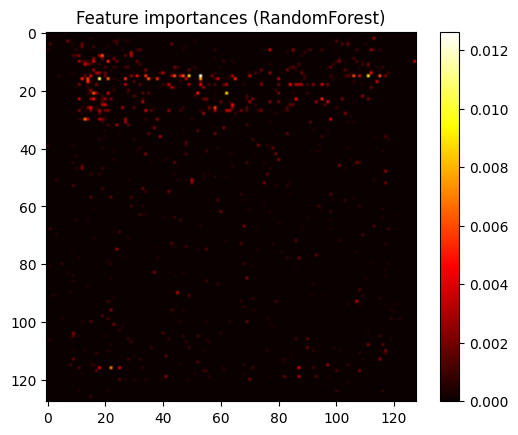

In [13]:
# Feature importance
importances = best_rfc.feature_importances_
plt.imshow(importances.reshape(128, 128), cmap='hot')
plt.title("Feature importances (RandomForest)")
plt.colorbar()
plt.show()

#### Questions
How to add this to the prediction? -> top 40 pixels most important.

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        99
           1       0.75      0.38      0.50        16

    accuracy                           0.90       115
   macro avg       0.83      0.68      0.72       115
weighted avg       0.88      0.90      0.88       115



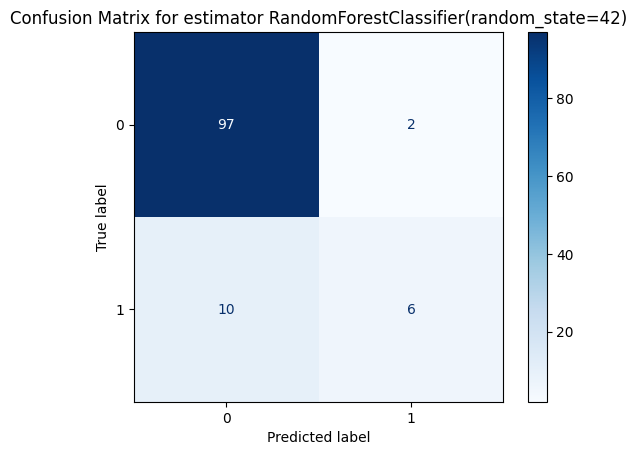

In [14]:
# add top 40 pixel importance.

X_reshape = X.reshape(-1, 128, 128)
top_40_sum = X_reshape[:, :40, :].sum(axis=(1, 2))

X_new = np.column_stack([X, top_40_sum])

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y, test_size=0.23, random_state=42, stratify=y
)

X_train_new_scaled = scaler.fit_transform(X_train_new)
X_test_new_scaled = scaler.transform(X_test_new)

rfc.fit(X_train_new_scaled, y_train_new)

model_evaluator(rfc, X_test_new_scaled, y_test_new)

In [15]:
y_proba = rfc.predict_proba(X_test_new_scaled)[:, 1]
threshold = 0.3
y_pred_lower = (y_proba >= threshold).astype(int)

print(classification_report(y_test_new, y_pred_lower))
print(confusion_matrix(y_test_new, y_pred_lower))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        99
           1       0.76      0.81      0.79        16

    accuracy                           0.94       115
   macro avg       0.87      0.89      0.88       115
weighted avg       0.94      0.94      0.94       115

[[95  4]
 [ 3 13]]


### Evaluation KNeighborClassifier

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        99
           1       1.00      0.50      0.67        16

    accuracy                           0.93       115
   macro avg       0.96      0.75      0.81       115
weighted avg       0.94      0.93      0.92       115



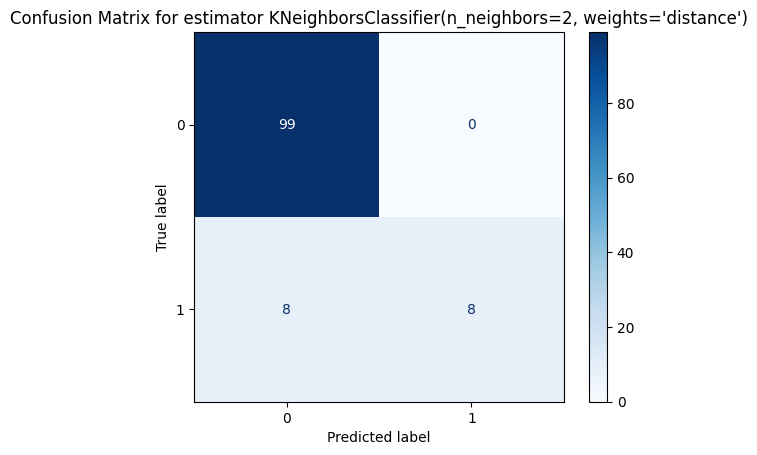

In [16]:
model_evaluator(best_knc, X_test_scaled, y_test)

### Conclusion of KNeighborClassifier
- Increase recall (lower threshold for TP)

In [17]:
y_proba = best_knc.predict_proba(X_test_scaled)[:, 1]
threshold = 0.2
y_pred_lower = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_lower))
print(confusion_matrix(y_test, y_pred_lower))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96        99
           1       0.89      0.50      0.64        16

    accuracy                           0.92       115
   macro avg       0.91      0.74      0.80       115
weighted avg       0.92      0.92      0.91       115

[[98  1]
 [ 8  8]]


### Evaluation SVC

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        99
           1       1.00      0.19      0.32        16

    accuracy                           0.89       115
   macro avg       0.94      0.59      0.63       115
weighted avg       0.90      0.89      0.85       115



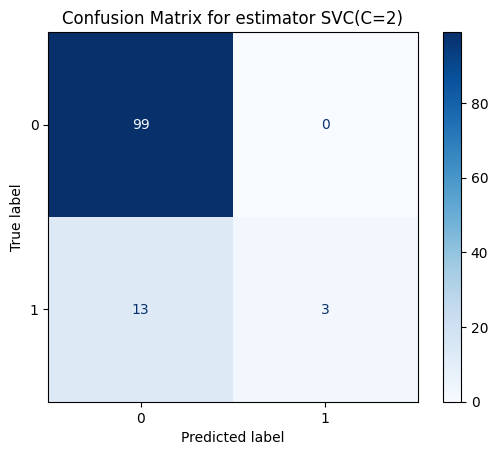

In [18]:
model_evaluator(best_svc, X_test_scaled, y_test)

### Evaluation LogisticRegressionCV

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        99
           1       0.71      0.31      0.43        16

    accuracy                           0.89       115
   macro avg       0.81      0.65      0.69       115
weighted avg       0.87      0.89      0.87       115



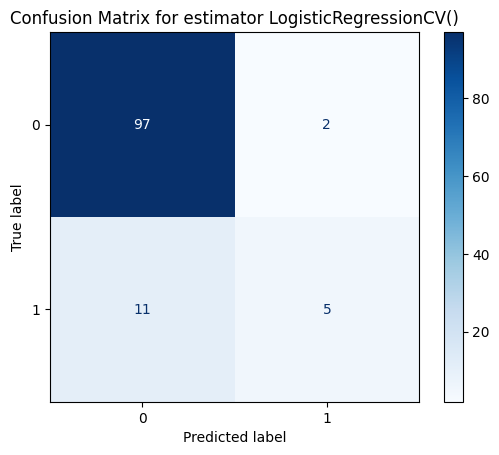

In [19]:
model_evaluator(best_lr, X_test_scaled, y_test)